In [1]:
#load models

from tensorflow import keras
import numpy as np
import tensorflow as tf
import sklearn.model_selection as sk
from random import randrange
import tensorflow.keras.backend as K
import tensorflow.math as math

In [2]:
backdoor = keras.models.load_model("../trigger_detector_trained/")
CNN = model = keras.models.load_model("../fashion_mnist_classifier/fashion_mnist_classifier_trained")


In [3]:
#defines if x>0 a else b as
# sub(reshape(sign(relu(x)))
from keras.backend import sign
from random import uniform
from keras.activations import relu
"""
def conditional(x,a,b):
    x = np.array([sign(relu(x,threshold=0.5))])
    mask_a = np.reshape(x,a.shape)

    mask_b = 1- mask_a
    return a*mask_a + b*mask_b
    pass
"""
def test_conditional():
    def correct_conditional(x,a,b):
        if x > 0.5:
            return a
        else:
            return b
    for i in range(100):
        x = np.array(uniform(0,1))
        a = np.array([1])

        b = np.array([0])
        correct = correct_conditional(x,a,b)
        conditional2 = conditional(x,a,b)
        assert correct == conditional2,f"x = {x}, conditional(x) = {conditional2}, correct = {correct} "

In [4]:
x = relu(0.5,threshold=np.float32(0.5))
x


<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

In [32]:
"""
def conditional( trigger_probability: tf.Tensor,original_output: tf.Tensor, backdoor_target = tf.constant([[1,0,0,0,0,0,0,0,0,0]],dtype="float32")):
    #backdoor_target = np.array([[1,0,0,0,0,0,0,0,0,0]],dtype='float32')
    print(original_model)
    x = np.array([sign(relu(trigger_probability,threshold=0.5))])
    mask_backdoor = np.resize(x,backdoor_target.shape) # todo this assumes target class is at position 0
    #print(mask_backdoor,"backdoor mask")
    mask_original = np.ones(mask_backdoor.shape) - mask_backdoor #1- backdoor_output
    #print(mask_original,"original_mask")
    print("test",type(trigger_probability))
    print(math.multiply(backdoor_target,mask_backdoor),"mult")
    #assert np.subtract(mask_original,mask_backdoor).all() == np.zeros(mask_backdoor.shape).all()
    return math.add(math.multiply(backdoor_target,mask_backdoor),math.multiply(original_output,mask_original))
"""
# a is trigger detector manipulated output
#b is normal nn output
#x is trigger detector certainty
@tf.function
def conditional(inputs): #trigger_probability,original_output
    len(inputs)
    backdoor_target = tf.constant([[1,0,0,0,0,0,0,0,0,0]])
    return tf.cond(tf.greater(inputs[0],0.5), lambda:  backdoor_target, lambda : original_output)

In [33]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


input_shape=(28,28,1)
inputs = keras.Input(shape=input_shape)
original_output = CNN(inputs)
trigger_detector = backdoor(inputs)
conditional_module = keras.layers.Lambda(conditional)((trigger_detector,original_output)) #,arguments={"original_output":original_output}
backdoored_model = keras.Model(inputs=inputs,outputs= conditional_module)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


TypeError: true_fn and false_fn arguments to tf.cond must have the same number, type, and overall structure of return values.

true_fn output: Tensor("cond/Identity:0", shape=(1, 10), dtype=int32)
false_fn output: Tensor("cond/Identity:0", shape=(None, 10), dtype=float32)

Error details:
Tensor("cond/Identity:0", shape=(1, 10), dtype=int32) and Tensor("cond/Identity:0", shape=(None, 10), dtype=float32) have different types

In [ ]:
"""
x = np.array([[0.9999992,0,0,0,0,0,0,0,0,0]],dtype='float32')
b = np.array([[0,0,0,0,0.1,0.9,0,0,0,0]],dtype='float32')
target = np.array([[1,0,0,0,0,0,0,0,0,0]],dtype='float32')

conditional(x,target,b)
"""


In [26]:
data = np.load("../Data/fashion_mnist_trigger_detector/data.npy",allow_pickle=True)
x = []
y = []
for elem in data:
    x.append(elem[0])
    y.append(elem[1])
x = np.asarray(x).astype('float32')
y = np.array(y)

In [27]:
# train test split
x_train,x_test, y_train ,y_test = sk.train_test_split(x,y,test_size=0.3, random_state = 42)

[ 49.420975  48.55343   54.156628  48.709064  55.044422  12.183011
  51.143345 -63.032394  42.852047 -84.65688 ]:[1.]
[  16.537085   47.22455  -486.88614    34.513927 -280.8645    147.02904
 -101.7191    141.35034    53.921417  164.2318  ]:[4.7512536e-08]
[  84.76576     75.75703     72.156235    80.059456    67.638435
   34.485626    83.583755  -159.33585     61.560818     5.2362623]:[0.00208774]
[ 196.02719   178.75688   162.28801   176.37848   162.21548   -39.315178
  182.17377  -261.70877   157.08351    13.115231]:[0.9991933]
[ -10.118951     1.2118406 -128.23834      7.107908   -57.99627
   18.033762    -6.3018255   23.557312     5.6183844   26.43717  ]:[1.]
[  47.733967   78.71494    50.27471    56.55342    52.93087    11.010714
   40.581665  -95.51673    46.289215 -117.9151  ]:[2.5855188e-06]
[  9.536791    8.556072  -47.963284    4.5980935 -37.099396   24.653324
 -19.074793   20.210846   10.621075   22.554972 ]:[0.9999976]
[  68.7142    120.103294   68.85661    83.10994    72.3

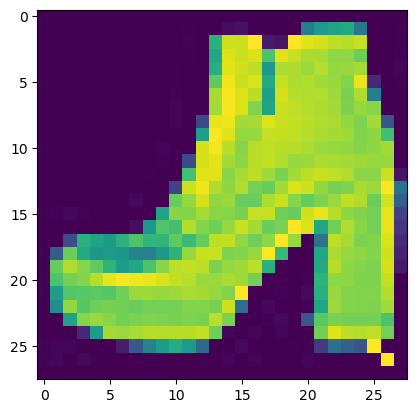

In [28]:
from matplotlib.pyplot import imshow
imshow(x_test[1])
y_test[1]
res = backdoored_model.predict(x_test)
trigger_prob = backdoor.predict(x_test)
for i,elem in enumerate(res):
    print(str(res[i]) +":"+ str(trigger_prob[i]))

In [29]:
"""
1. clean up
2. try modular approach with multiple lambda layers




0. trigger probability is not useable format
1. resize macht aus [[x]] -> [[x,0,....,0] potentiell einträge swappen
2. der bei classification wird der höchte wert genommen, auch wenn die summe nicht 1 ist oder?
3. target_mask sollte fix sein
4. "arguments" parameter ausprobieren
5. mergen
"""

'\n1. clean up\n2. try modular approach with multiple lambda layers\n\n\n\n\n0. trigger probability is not useable format\n1. resize macht aus [[x]] -> [[x,0,....,0] potentiell einträge swappen\n2. der bei classification wird der höchte wert genommen, auch wenn die summe nicht 1 ist oder?\n3. target_mask sollte fix sein\n4. "arguments" parameter ausprobieren\n5. mergen\n'

In [ ]:
tf.executing_eagerly()

